# PyTorch 튜토리얼 2

## Transfer Learning 튜토리얼

### Transfer Learning 이란
딥러닝을 feature extractor로만 사용하고 그렇게 추출해낸 피처를 이용하여 다른 모델을 학습하는 것으로, 충분히 학습할 데이터가 없거나,
학습을 위한 서버컴퓨터가 없거나 하는 등의 이유로 VGG, ResNet등 이미 사전에 학습이 완료된 모델(Pre-Training Model)을 가지고 사용자가
원하는 학습을 위해 미세 조정을 하여 학습시키는 방법이다. 요약하면, 이미 학습된 weight들을 transfer하여 자신의 모델에 맞게 학습을 
시키는 방법이다.

Transfer Network를 사용하는 데는 3가지 방법이 있다.
 * **Feature extraction**<br> 
    Feature extraction은 미리 학습된 ConvNet을 사용하여, 마지막으로 연결된 레이어(Output 레이어)를 제거한 다음, 해당 부분이 피쳐를<br>
    출력하게 하여 Feature extraction로 사용하는 방법이다. <br>
 * **Fintuning ConvNet**<br>
    Fintuning ConvNet은 위의 Feature extraction에서 마지막의 classification layer만을 retrain하는 것이 아니라 pretrain된 전체 <br>
    네트워크를 fine-tuning하여 사용 하는 방법으로 Backword Propgation을 계속 하여 학습된 네트워크의 weight를 업데이트 하는 방법이다.<br>
 * **Pretrained models**<br>
    Pretrained models는 사전에 훈련된 다양한 모델(VGG, ResNet)등의 다양한 ConvNet의 최종 체크 포인트를 받아 사전 훈련된 모델의<br>
    네트워크를 미세 조정하여 사용하는 방법이다.<br>
    
Transfer Learning은 결국 신경망에 fine-tune을 사용하는 것이 핵심인 방법이다. 그렇다면 fine-tune은 언제 하여야 할까?<br>
fine-tune을 어떻게 할지 결정하기 위해서는 몇가지 요인을 살펴봐야 하는데, 가장 중요한 요소는 새로 사용할 데이터세트의 크기와, 원본 데이터 세트와의 유사성이 있다. 이를 통해 4가지 시나리오에 따라 fine-tune을 할 수 있다.

* 1.새로운 데이터 세트가 작으며 원본 데이터 세트와 유사할 경우, 데이터가 작기 때문에 ConvNet이 잘 학습하지 못한다.<br>
    이런 경우 ConvNet 전체를 fine-tune하는 것은 좋지 않으며, 데이터가 원본 데이터와 유사하기 때문에 ConvNet의 상위 수준 피쳐 역시<br>
    이 데이터 집합과 관련이 있다고 예상할 수 있게 된다. 따라서 해당 경우에는 선형 분류기만 훈련시키는 것이 가장 좋은 방법이다.<br>
* 2.새로운 데이터 세트는 크고 원본 데이터 세트와 유사한 경우, 더 많은 데이터를 보유하고 있어 전체 네트워크에 대해 fine-tune을<br>
    시행하다보면 오버피팅이 될 가능성이 높다. 따라서 일부 레이어에 한해서 fine-tune을 하는 것이 좋다.<br>
* 3.새로운 데이터 세트는 작으며, 원본 데이터 세트와 매우 다를 경우, 데이터가 작기 때문에 선형 분류기만을 학습하고 원본 데이터셋과<br>
    많이 다르기 때문에 데이터 세트와 연관성이 많은 피쳐를 포함한 레이어는 연결하는 것이 좋지 않다. 대신 초반부 레이어와 SVM 분류기를<br>
    (주어진 데이터 집합을 바탕으로 하여 새로운 데이터가 어느 카테고리에 속할지 판단하는 비확률적 이진 선형 분류 모델)<br>
    연결하는 방법이 효과적이다.
* 4.새로운 데이터 세트는 크고 원본 데이터 세트와 매우 다르다면, 데이터 세트가 매우 크기 때문에 미리 학습되있던 모델의 가중치를 초기화<br> 
    하면서 ConvNet을 처음부터 학습 시키는 것이 좋다.
   

### Pytorch Transfer Learning
해당 튜토리얼에서는 매우 큰 데이터셋에 대해 사전 학습한 ConvNet을 고정 특징 추출기(fixed feature extractor)로 사용한다.<br>
이를 위해 해당 튜토리얼에서는 다음과 같은 과정을 거친다.

 * 합성곱 신경망의 미세조정 - 신경망을 ImageNet1000등의 데이터셋으로 미리 학습한 신경망으로 초기화한다.
 * 고정 특정 추출기로써의 신경망 - 마지막 레이어를 제외한 모든 신경망의 가중치를 고정한다. 이를 통해서 마지막의 연결된 계층은 새로운 무작위 가중치를 갖는 계층으로 대체되어 이 계층만 학습하게 된다.
 
해당 튜토리얼에서는 위와 같은 과정을 Pytorch로 구현하며, 개미와 벌을 분류하는 모델을 학습하는 과정을 구현한다. 각각의 분류에는 75개의 validation data가 있다. 기본적으로 적은 데이터이기에, 전이학습을 사용하여야 한다.
 
먼저 필요한 모듈들을 임포트 한다.

In [14]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

### 데이터 불러오기
해당 튜토리얼의 데이터는 수동으로 받아야한다. https://download.pytorch.org/tutorial/hymenoptera_data.zip
지난 시간에 다루었던 torchvision과 torch.utils.data 모듈을 통해 데이터들을 가져와 노말라이즈 한다.

In [5]:
# 학습을 위한 데이터 증가(Augmentation)와 일반화하기
# 단지 검증을 위한 일반화하기
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

데이터를 제대로 불러오고, 알맞은지 일부 이미지를 시각화해본다.

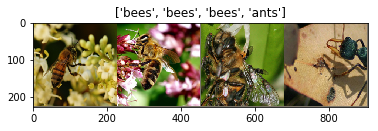

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### 모델 학습하기
모델을 학습하기 위한 일반 함수를 작성한다. 해당 과정에서 해야 할것들은 다음과 같다.
 * Learning Rate Scheduling
 * 최적의 모델을 구하여 저장

아래에서 scheduler 매개변수는 torch.optim.lr_scheduler 의 LR Scheduler 객체(Object)이다.

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### 모델의 예측값 시각화하기
학습한 모델을 이용한 결과물을 보여주는 함수를 작성한다.

In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### ConvNet Finetuning
사전 학습한 모델을 불러온 후 마지막 레이어 계층을 reset한다.

In [10]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### 학습 및 평가

In [11]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5906 Acc: 0.7131
val Loss: 0.4889 Acc: 0.8170

Epoch 1/24
----------
train Loss: 0.5228 Acc: 0.7746
val Loss: 0.3399 Acc: 0.8562

Epoch 2/24
----------
train Loss: 0.6025 Acc: 0.7336
val Loss: 0.3034 Acc: 0.8824

Epoch 3/24
----------
train Loss: 0.6249 Acc: 0.7664
val Loss: 0.4926 Acc: 0.8301

Epoch 4/24
----------
train Loss: 0.5365 Acc: 0.8074
val Loss: 0.5692 Acc: 0.8824

Epoch 5/24
----------
train Loss: 0.7846 Acc: 0.7500
val Loss: 0.6494 Acc: 0.7908

Epoch 6/24
----------
train Loss: 0.6837 Acc: 0.7459
val Loss: 0.3565 Acc: 0.8693

Epoch 7/24
----------
train Loss: 0.3824 Acc: 0.8525
val Loss: 0.3420 Acc: 0.8824

Epoch 8/24
----------
train Loss: 0.3481 Acc: 0.8361
val Loss: 0.3465 Acc: 0.8954

Epoch 9/24
----------
train Loss: 0.3622 Acc: 0.8525
val Loss: 0.3526 Acc: 0.8693

Epoch 10/24
----------
train Loss: 0.3568 Acc: 0.8525
val Loss: 0.3242 Acc: 0.8693

Epoch 11/24
----------
train Loss: 0.2502 Acc: 0.9098
val Loss: 0.3107 Acc: 0.8824

Ep

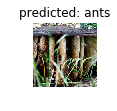

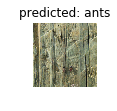

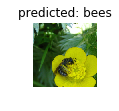

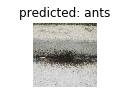

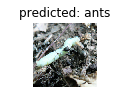

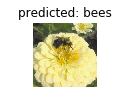

In [12]:
visualize_model(model_ft)

### 고정 특정 추출기로써의 합성곱 신경망
이제 신경망이 특정 추출기로써의 역할을 하게 하기 위해 마지막 계층을 제외한 모든 신경망을 고정할 필요가 있다. requires_grad == False 를 설정하여 매개변수를 고정하여 backward() 에서 경사도(gradient)가 계산되지 않도록 하면 된다.

In [13]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [14]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6035 Acc: 0.6639
val Loss: 0.2476 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.5662 Acc: 0.7500
val Loss: 0.2033 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.3331 Acc: 0.8770
val Loss: 0.2587 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.5399 Acc: 0.7910
val Loss: 0.3636 Acc: 0.8562

Epoch 4/24
----------
train Loss: 0.7161 Acc: 0.7213
val Loss: 0.2539 Acc: 0.9020

Epoch 5/24
----------
train Loss: 0.4875 Acc: 0.7787
val Loss: 0.1748 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.4255 Acc: 0.8238
val Loss: 0.1692 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3728 Acc: 0.8730
val Loss: 0.1619 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.3482 Acc: 0.8689
val Loss: 0.1579 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.3288 Acc: 0.8648
val Loss: 0.1777 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.3945 Acc: 0.8443
val Loss: 0.1724 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.3018 Acc: 0.8893
val Loss: 0.1835 Acc: 0.9477

Ep

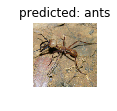

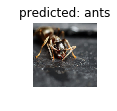

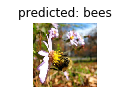

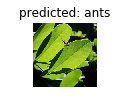

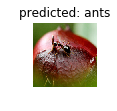

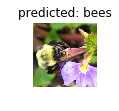

In [15]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## Data Loading and Processing
    기계학습 문제를 해결하기 위해서는 데이터의 준비에 많은 노력을 부어야 한다. PyTorch는 데이터를 좀 더 쉽게 사용할 수 있도록 많은 
    도구를 제공한다. 해당 튜토리얼에서는 데이터 세트에서 데이터를 로드하고 사전 처리/ 보강하는 방법을 살펴 본다.
    
    해당 튜토리얼에서는 다음과 같은 패키지가 설치 되어 있어야 한다.
    
    scikit-image: 이미지 io 및 변환 용
    pandas: 더 쉬운 csv 파싱

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

해당 튜토리얼에서 다루어볼 데이터 세트는 얼굴 포즈의 데이터 세트이다. 해당 데이터셋에는 얼굴에 다음 이미지와 같은 주석이 추가되어 있다.<br>
![face](Asset\landmarked_face2.png)

해당 데이터셋 들은 68개의 포인트로 얼굴에 주석으로 표시해준다.<br><br>
https://download.pytorch.org/tutorial/faces.zip 에서 faces 데이터 셋을 다운로드 한다. 해당 데이터셋들은 dlib의<br>
Real-Time Face Pose Estimation을 적용하여 나온 데이터셋들이다.<br><br>
데이터 세트에는 얼굴 표정을 담은 이미지 파일과 다음과 같은 csv 파일이 제공된다.

image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x, ... ,part_67_x,part_67_y<br>
0805personali01.jpg,27,83,27,98, ... 84,134<br>
1084239450_e76e00b7e7.jpg,70,236,71,257, ... ,128,312<br>

CSV파일을 읽어 (N,2) 배열로 얼굴 표정의 포인트를 가져온다. N은 포인트의 수이다.

In [3]:
landmarks_frame = pd.read_csv('faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


다음은 이미지와 포인트가 제대로 적용이 되었는지 확인하기 위한 함수이다.

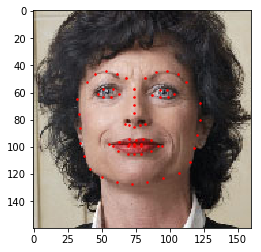

In [5]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('faces/', img_name)),
               landmarks)
plt.show()

### Dataset Class
torch.utils.data.Dataset은 데이터 집합을 나타내는 추상 클래스 이다. 사용자 지정 데이터 집합은 Dataset을 상속하고 다음 함수를 재정의 하여야 한다.<br><br>
   
    __len__ : len (dataset)은 데이터 집합의 크기를 반환한다.
    __getitem__ : dataset[i] 를 사용하여 i 번째 샘플을 가져올 수 있도록 색인 생성을 지원하기위해 사용
    
얼굴 표식 데이터 세트를 위한 데이터 세트 클래스를 생성합니다. init에서 csv를 읽어 들이고, getitem에서 이미지를 읽어 들인다.<br>
이것은 모든 이미지가 동시에 메모리에 저장되지 않고 필요에 따라 읽히기 때문에 메모리 측면에서 효율적이다.<br>
<br>
데이터 세트의 샘플은 {'image': image, 'landmarks': landmarks}라는 dic형이 된다. dataset은 샘플에 필요한 처리를 적용 할 수 있도록 선택적 인수 변환을 사용한다. 

In [6]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

해당 클래스를 인스턴스화 하고 데이터 샘플을 출력해 본다. 처음 4개 샘플의 크기를 출력하고 포인트를 표시한다.

0 (324, 215, 3) (68, 2)


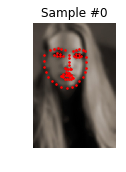

1 (500, 333, 3) (68, 2)


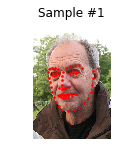

2 (250, 258, 3) (68, 2)


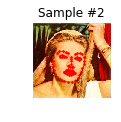

3 (434, 290, 3) (68, 2)


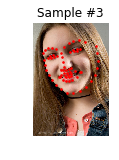

In [9]:
face_dataset = FaceLandmarksDataset(csv_file='faces/face_landmarks.csv',
                                    root_dir='faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

### Transforms
위에서 보다시피, 샘플에는 문제점이 하나 있다. 샘플 이미지의 크기가 동일하지 않다는것이 문제다. 대부분의 신경망은 고정된 크기의 이미지를<br>
input으로 받으며, 따라서 이것을 해결하는 것을 먼저 만들어야 한다. 이를 위해 3가지 함수를 만들어야 한다.

* Rescale: 이미지 배율 조정
* RandomCrop: 임의로 잘라내 확대
* ToTensor: numpy 이미지를 토치 이미지로 변환 (축도 교환해 주어야 한다.)

이 함수들은 함수로 만드는 대신 호출 가능한 클래스로 작성하여 변환의 매개 변수를 호출 할 때마다 전달할 필요가 없다.<br>
이를 위해서는 __call__ 함수와 필요한 경우 __init__ 함수를 구현하면된다. 해당 함수들을 이용하면 다음과 같은 변환을 사용 할 수 있게된다.

In [16]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

구현한 함수를 샘플에 적용시켜 본다.<br>
다음은 이미지의 크기를 256x256으로 변환하고, 랜덤하게 224의 크기로 크롭하는 코드이다.<br><br>
이를 위해 composed = transforms.Compose([Rescale(256), RandomCrop(224)])라는 코드를 넣게 되는데, 이는 다음과 같이 작동한다.<br><br>
for i, tsfrm in enumerate([scale, crop, composed]):<br>
i=0, tsfrm=scale<br>
i=1, tsfrm=crop<br>
i=2, tsfrm=composed<br>

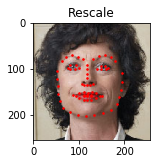

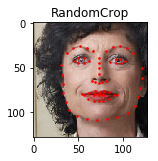

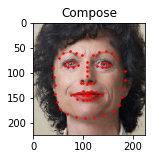

In [17]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

### Iterating through the dataset
지금까지 위에서 했던 작업들을 조합하여 composed 변환을 사용하여 데이터 세트를 만들어준다. 이로써 데이터 세트가 샘플링 될 때 마다 다음과 같은 과정을 거치게 된다.<br>
* 파일에서 이미지를 읽는다
* 읽어들인 이미지에 변환을 적용한다.
* 적용한 변환 중 하나(RandomResizeCrop)가 무작위이므로 샘플링시 데이터가 증가하게 된다.
아래 코드는 위의 과정을 구현하는 코드이다.

In [18]:
transformed_dataset = FaceLandmarksDataset(csv_file='faces/face_landmarks.csv',
                                           root_dir='faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


단, 위와 같은 루프를 사용하면 여러가지 feature를 놓치게 된다. 특히 다음 3가지에 대해 더 놓치게 된다.
* 데이터 일괄 처리
* 데이터 섞기
* multiprocessing 작업자를 사용하여 데이터를 병렬로 로드<br>

이렇게 루프를 사용하여 놓치게 되는 일을 방지하기 위해 PyTorch는 torch.utils.data.DataLoader를 준비하였다.<br>
torch.utils.data.DataLoader는 collate_fn이라는 매개 변수를 가지며, collate_fn을 통해 샘플을 일괄처리 하는 방법을 지정할 수 있다.<br>
다음은 DataLoader을 사용하여 데이터를 불러오고 제대로 불러왔는지 4개의 이미지를 Landmark와 함께 호출하는 코드다.

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


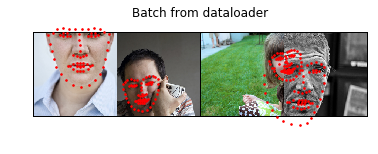

In [20]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=0)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

### torchVision
torchvision 패키지는 몇가지 공통적인 데이터 세트 및 변형을 제공해주며 사용자 정의 클래스를 따로 사용할 필요가 없다.<br>
torchvision의 imageFolder를 이용하면 이를 쉽게 구현 할 수 있다. ImageFolder는 데이터들이 다음과 같은 방식으로 구성되 있다고 가정 할 경우,

    root/ants/xxx.png
    root/ants/xxy.jpeg
    root/ants/xxz.png
    .
    .
    .
    root/bees/123.jpg
    root/bees/nsdf3.png
    root/bees/asd932_.png

ImageFolder는 데이터 안에서 클래스 레이블들을 자동으로 인식하여 전달해준다. 다음은 전이학습 예제에서 ImageFolder를 사용하여 데이터를 불러온 부분이다.

In [21]:
import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
hymenoptera_dataset = datasets.ImageFolder(root='hymenoptera_data/train',
                                           transform=data_transform)
dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset,
                                             batch_size=4, shuffle=True,
                                             num_workers=4)